In [1]:
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as F
import os
import copy
import configparser
import random
import skimage.io
from skimage import img_as_ubyte

import matplotlib
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from utils import load_config, test_model_under_patch, \
                   get_patch, plot, predict, generate_smoothed_adv_binary, plot_5x5, predict_5x5, \
                    generate_smoothed_adv_multi_cls

from attacks import PGD_L2

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Binary Classifier

In [2]:
# Load dataloader and poisoned classifier
dataloaders_dict, classifier, denoised_classifier, orig_trigger = load_config(cfg_id=1)

In [3]:
# Test Model's accuracy with the original backdoor trigger
test_model_under_patch(classifier, dataloaders_dict, orig_trigger)

Accuracy under current trigger: 0.9040


In [4]:
epsilon = 60
num_steps = 100
num_noise_vec = 16
noise_sd = 1.00
step_size = 2 * epsilon / num_steps
targeted = False

In [5]:
dataloader = dataloaders_dict['notpatched']

attacker = PGD_L2(steps=num_steps, max_norm=epsilon)

denoised_classifier.eval()   # Set model to evaluate mode

# Generate adversarial examples of the smoothed classifier
clean_img_list, adv_img_list = generate_smoothed_adv_binary(dataloader, attacker, denoised_classifier, 
                                                    num_noise_vec=num_noise_vec, 
                                                    noise_sd=noise_sd, 
                                                    step_size=step_size)

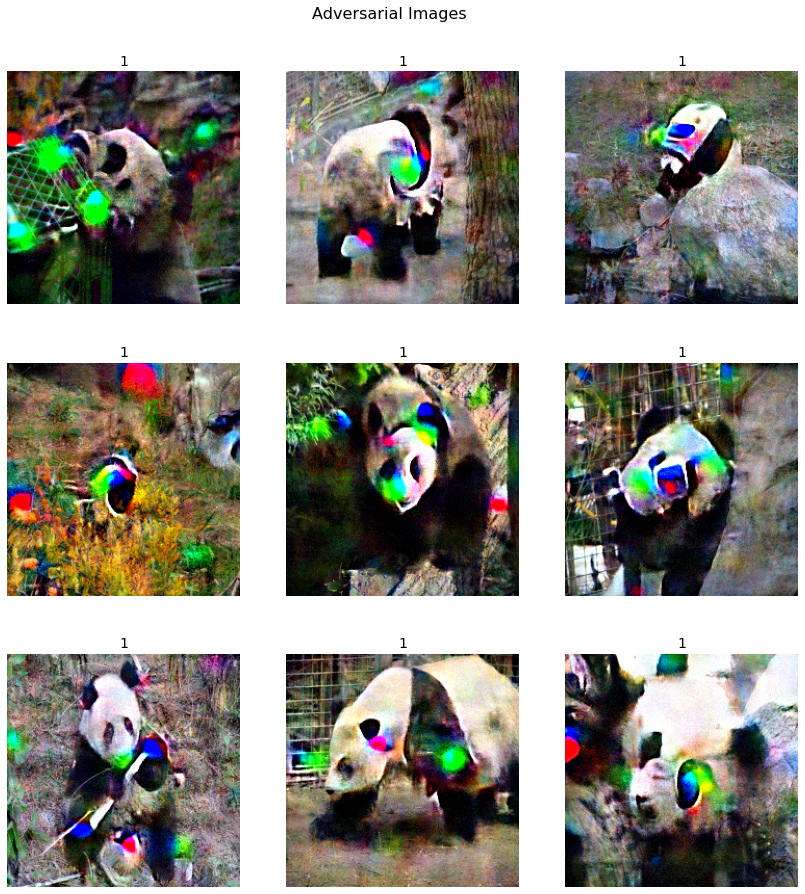

In [6]:
adv_pred = predict(classifier, adv_img_list)
plot(adv_img_list, "Adversarial Images", adv_pred.tolist(), length=15, save_path=None)

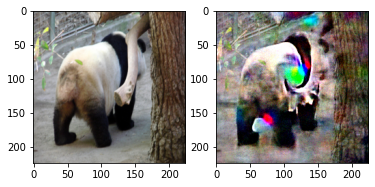

In [7]:
img_id = 1

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(clean_img_list[img_id])
axs[1].imshow(adv_img_list[img_id])

### Color patch

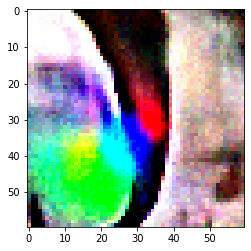

In [8]:
patch=get_patch(adv_img_list[img_id], 50, 100, 60, 60)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

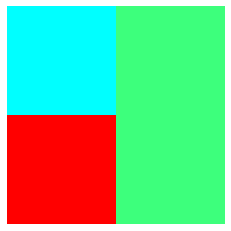

In [9]:
patch_new = np.zeros((30,30,3)) 
patch_new[:,15:30,0] = patch[50,10,0]
patch_new[:,15:30,1] = patch[50,10,1]
patch_new[:,15:30,2] = patch[50,10,2]

patch_new[0:15,0:15,0] = patch[40,25,0]
patch_new[0:15,0:15,1] = patch[40,25,1]
patch_new[0:15,0:15,2] = patch[40,25,2]

patch_new[15:30,0:15,0] = patch[30,33,0]
patch_new[15:30,0:15,1] = patch[30,33,1]
patch_new[15:30,0:15,2] = patch[30,33,2]

plt.imshow(patch_new)
plt.axis('off')

In [10]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Accuracy under current trigger: 0.9380


### Cropped patch

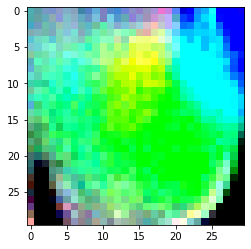

In [11]:
patch=get_patch(adv_img_list[img_id], 80, 100, 30, 30)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

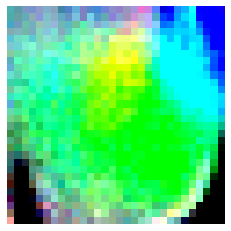

In [12]:
patch_new = np.copy(patch) 

plt.imshow(patch_new)
plt.axis('off')

In [13]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Accuracy under current trigger: 0.9900


## Multi-class Classifier

In [14]:
# Load dataloader and poisoned classifier
# For multi-class classifier, the batch size is set to 1 for the code to work;
dataloaders_dict, classifier, denoised_classifier, orig_trigger = load_config(cfg_id=4)

In [15]:
# Test Model's accuracy with the original backdoor trigger
test_model_under_patch(classifier, dataloaders_dict, orig_trigger)

Accuracy under current trigger: 0.7260


In [16]:
epsilon = 60
num_steps = 100
num_noise_vec = 16
noise_sd = 1.00
step_size = 2 * epsilon / num_steps

In [19]:
dataloader = dataloaders_dict['test']

attacker = PGD_L2(steps=num_steps, max_norm=epsilon)

denoised_classifier.eval()   # Set model to evaluate mode

clean_img_list, adv_img_list = generate_smoothed_adv_multi_cls(dataloader, attacker, denoised_classifier, 
                                                    num_noise_vec=num_noise_vec, 
                                                    noise_sd=noise_sd, 
                                                    step_size=step_size)

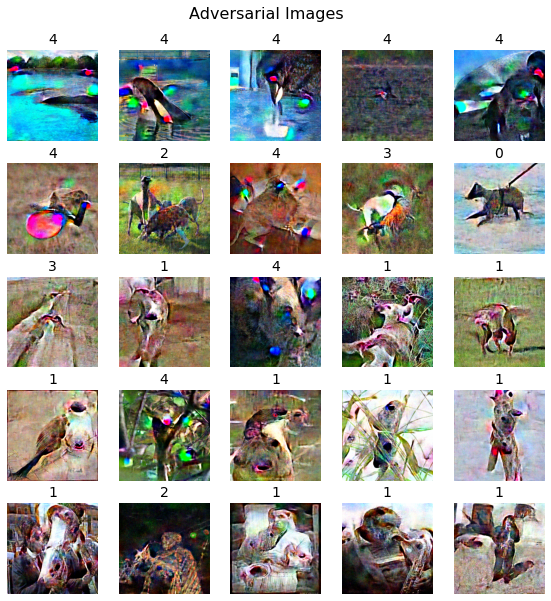

In [20]:
adv_pred = predict_5x5(classifier, adv_img_list)
plot_5x5(adv_img_list, "Adversarial Images", adv_pred, save_path=None)

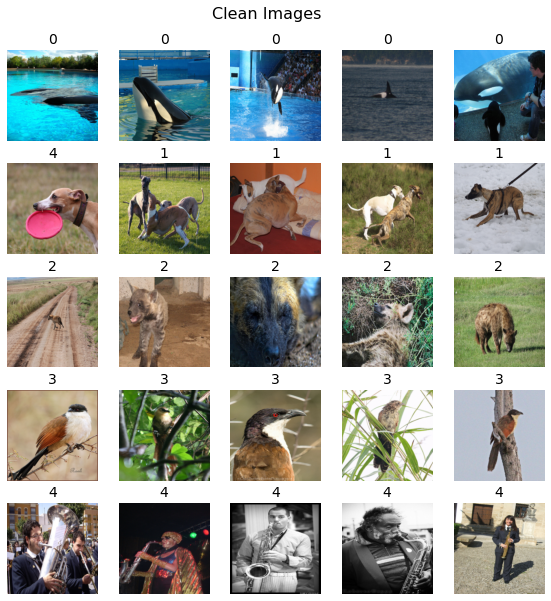

In [21]:
clean_pred = predict_5x5(classifier, clean_img_list)
plot_5x5(clean_img_list, "Clean Images", clean_pred)

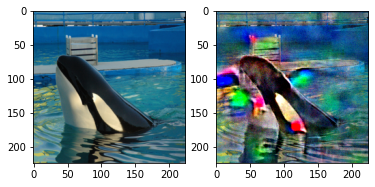

In [22]:
img_i, img_j = 0, 1

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(clean_img_list[img_i][img_j])
axs[1].imshow(adv_img_list[img_i][img_j])

### Color patch

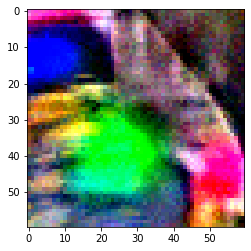

In [24]:
patch=get_patch(adv_img_list[img_i][img_j], 90, 10, 60, 60)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

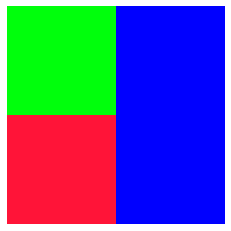

In [25]:
patch_new = np.zeros((30,30,3)) 
patch_new[:,15:30,0] = patch[10,5,0]
patch_new[:,15:30,1] = patch[10,5,1]
patch_new[:,15:30,2] = patch[10,5,2]

patch_new[0:15,0:15,0] = patch[40,20,0]
patch_new[0:15,0:15,1] = patch[40,20,1]
patch_new[0:15,0:15,2] = patch[40,20,2]

patch_new[15:30,0:15,0] = patch[50,50,0]
patch_new[15:30,0:15,1] = patch[50,50,1]
patch_new[15:30,0:15,2] = patch[50,50,2]

plt.imshow(patch_new)
plt.axis('off')

In [26]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Accuracy under current trigger: 0.8455


### Cropped patch

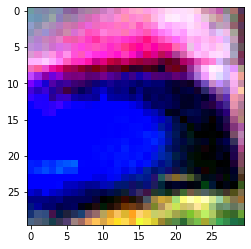

In [28]:
patch=get_patch(adv_img_list[img_i][img_j], 85, 5, 30, 30)

plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

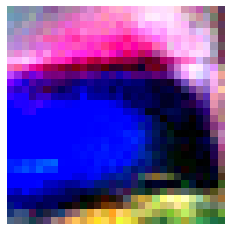

In [29]:
patch_new = np.copy(patch)

plt.imshow(patch_new)
plt.axis('off')

In [30]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Accuracy under current trigger: 0.7685
